In [1]:
import pandas as pd
import pylab as plt
import os
from glob import glob
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('../forecast_pipeline/pipeline_data/steps.dat', 'r') as handle:
    steps = handle.readline().strip().split()
     
gnd_fname = glob('../forecast_pipeline/pipeline_data/data_????-??-??.csv')[0]
df_gnd = pd.read_csv(gnd_fname, dtype={'fips': str}).set_index('fips')

## Functions

In [3]:
def get_plot_data(target_type, method):
    data = {}
    for i in range(len(steps)):
        gnd = df_gnd[f'{target_type}{i}'].sum()
        gnd_date = steps[i]

        if gnd_date in data:
            data[gnd_date]['gnd'] = gnd
        else:
            data[gnd_date] = {'gnd': gnd}

        prd_fname = f'results/{steps[i]}_{target_type}_method-{method}.csv'
        if os.path.isfile(prd_fname):
            df_forecast = pd.read_csv(prd_fname)
            df_forecast_nation = df_forecast[df_forecast.location=='US']
            target_end_dates = df_forecast_nation['target_end_date'].unique()


            for d in target_end_dates:
                tmp = df_forecast_nation[df_forecast_nation.target_end_date == d]
                horizon = int(tmp['target'].values[0].split(' ')[0])

                point = tmp[tmp['type'] == 'point']['value'].values[0]

                if d in data:
                    data[d][f'prd_{horizon}'] = point
                else:
                    data[d] = {f'prd_{horizon}': point}
    
    return pd.DataFrame(data=data).T

In [4]:
def plot_and_save(target_type):

    fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

    dfs  = []
    for method in [0, 1, 2]:
        df = get_plot_data(target_type=target_type, method=method)
        col_map = {'gnd': f'gnd-{method}', 'prd_1': f'prd-{method}_1', 'prd_2': f'prd-{method}_2'}
        df = df[['gnd', 'prd_1', 'prd_2']].rename(columns=col_map)
        dfs.append(df)
        ax = axes[method]
        df.plot(ax=ax, marker='o')
        ax.set_xticks(range(len(steps)))
        ax.set_xticklabels(steps)
        ax.tick_params(axis='x', rotation=45)
        ax.set_title(f'method {method}', fontsize=25)

    df_compare = pd.concat(dfs, axis=1).drop(['gnd-0', 'gnd-1'], axis=1).rename(columns={'gnd-2': 'gnd'})
    df_compare.to_csv(f'results/methodCompare_{target_type}_ours.csv', float_format='%.0f')

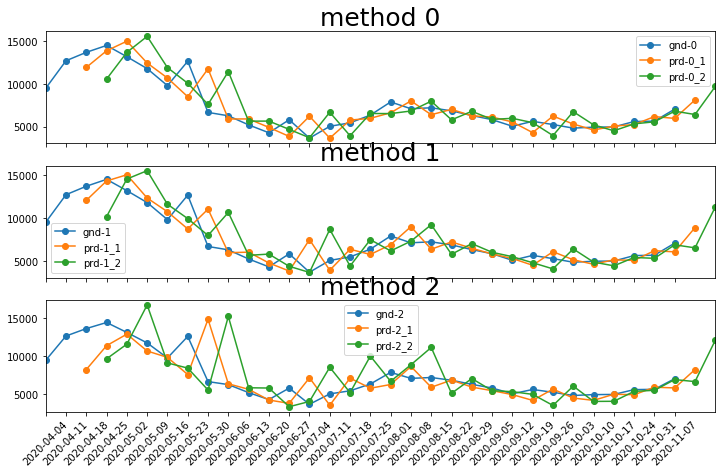

In [5]:
target_type = 'death'
plot_and_save(target_type)

In [6]:
# for target_type in ['case', 'death']: 
for target_type in ['death']: 
    print(f'\n=========== {target_type} ===========')
    otherTeam_fname = f'../otherTeam/data_processed/otherTeam_{target_type}.csv'
    df_otherTeams = pd.read_csv(otherTeam_fname, index_col=0)
    # df_otherTeams = df_otherTeams.rename(columns={col: col.split('-')[0] for col in df_otherTeams.columns})
    # print(df_otherTeams.head())
    
    ours_fname = f'results/methodCompare_{target_type}_ours.csv'
    df_ours = pd.read_csv(ours_fname, index_col=0)[['gnd', 'prd-0_1']].rename(columns={'prd-0_1': 'UnIT'})
    # print(df_ours.head())
    
    df_combined = df_ours.join(df_otherTeams, how='outer').dropna()
    # print(df_combined)
    
    df_err = pd.DataFrame(index=df_combined.index)
    for col in df_combined.columns:
        if col == 'gnd':
            continue
        df_err[col] = df_combined[col] - df_combined['gnd']
    mabs = df_err.abs().mean().sort_values(ascending=False)
    df_mabs = pd.DataFrame({'team': mabs.index, 'err': mabs.values})
    df_mabs.to_csv(f'data/compare_with_otherTeams_{target_type}_err_raw.csv', index=False, float_format='%.0f')
    # rmse = df_err.pow(2).mean().pow(.5).sort_values()

    print(mabs)
    # print(rmse)

    # df_combined = pd.concat(dfs, axis=1, join='outer').round(0)
    # df_combined.to_csv(f'results_time/compare_with_otherTeams_{target_type}.csv', float_format='%.0f')


=========== death ===========
UMich-RidgeTfReg         1523.7500
LANL-GrowthRate          1104.0625
JHU_IDD-CovidSP           916.3125
Geneva-DetGrowth          602.0625
UCLA-SuEIR                601.0625
UnIT                      597.6250
CU-scenario_low           578.2500
COVIDhub-baseline         564.2500
CU-scenario_mid           559.3750
CU-nochange               557.5000
CU-select                 551.1875
CU-scenario_high          550.5625
Columbia_UNC-SurvCon      504.9375
OliverWyman-Navigator     445.1875
COVIDhub-ensemble         384.0625
QJHong-Encounter          372.3125
dtype: float64
